In [1]:
import torch
from config import load_config
from main import load_model, get_device, count_labels
from builders import build_transform, build_dataloader
from builders import build_model, build_modeler, build_trainer
from main import show_results

/home/nampl/anaconda3/envs/pytorch_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
experiment_dir = './experiments/20250906_171558_mvtec_vanilla_vae'
config = load_config(experiment_dir)

test_transform = build_transform(config.test_transform_type, **config.test_transform_params)
dataloader = build_dataloader(config.dataloader_type, **config.dataloader_params,
    train_transform=None, test_transform=test_transform)
test_loader = dataloader.test_loader()

normal_count, anomaly_count = count_labels(test_loader.dataset)
print(f"Normal samples: {normal_count}")
print(f"Anomaly samples: {anomaly_count}")
print(f"Total samples: {normal_count + anomaly_count}")

 > Config loaded: config_20250906_171558_mvtec_vanilla_vae.json
Normal samples: 34
Anomaly samples: 63
Total samples: 97


In [3]:
model = build_model(config.model_type, **config.model_params)
loaded_model = load_model(model, experiment_dir)
device = get_device()
loaded_model = loaded_model.to(device)

 > Model loaded: model_20250906_171558_mvtec_vanilla_vae.pth


In [4]:
sample_batch = next(iter(test_loader))

print("\n=== Single Batch Inference Test ===")
with torch.no_grad():
    images = sample_batch['image'].to(device)
    labels = sample_batch['label'].to(device)
    print(f" > Input shape: {images.shape}")

    loaded_model.eval()
    outputs = loaded_model(images)
    print(f" > Output type: {type(outputs)}")
    print(f" > Output keys: {list(outputs.keys())}")
    print(f" > Prediction scores shape: {outputs['pred_score'].shape}")


=== Single Batch Inference Test ===
 > Input shape: torch.Size([2, 3, 256, 256])
 > Output type: <class 'dict'>
 > Output keys: ['pred_score', 'anomaly_map']
 > Prediction scores shape: torch.Size([2, 1])


In [5]:
modeler = build_modeler(config.modeler_type, model=loaded_model)
trainer = build_trainer(config.trainer_type, modeler=modeler)

In [6]:
results = trainer.test(test_loader)
show_results(results)


------------------------------------------------------------
EXPERIMENT RESULTS
------------------------------------------------------------
 > AUROC:             0.4080
 > AUPR:              0.6336
 > Threshold:         3.242e-01
------------------------------------------------------------
 > Accuracy:          0.6495
 > Precision:         0.6495
 > Recall:            1.0000
 > F1-Score:          0.7875



### 1. 환경 설정 및 임포트

In [10]:
# 이제 predictions를 활용한 심화 분석
predictions = trainer.predict(test_loader)
gt_labels = predictions['labels']
pred_scores = predictions['pred_scores']
anomaly_maps = predictions['anomaly_maps']

print("\n" + "="*60)
print("DETAILED ANALYSIS & VISUALIZATION")
print("="*60)

# === 점수 분포 상세 분석 ===
print("\n=== Score Distribution Details ===")
normal_mask = gt_labels == 0
anomaly_mask = gt_labels == 1
normal_scores = pred_scores[normal_mask]
anomaly_scores = pred_scores[anomaly_mask]

print(f"Normal samples: {len(normal_scores)}")
print(f"  Mean ± Std: {normal_scores.mean():.6f} ± {normal_scores.std():.6f}")
print(f"  Percentiles: 25%={torch.quantile(normal_scores, 0.25):.6f}, 50%={torch.quantile(normal_scores, 0.5):.6f}, 75%={torch.quantile(normal_scores, 0.75):.6f}")

print(f"Anomaly samples: {len(anomaly_scores)}")
print(f"  Mean ± Std: {anomaly_scores.mean():.6f} ± {anomaly_scores.std():.6f}")
print(f"  Percentiles: 25%={torch.quantile(anomaly_scores, 0.25):.6f}, 50%={torch.quantile(anomaly_scores, 0.5):.6f}, 75%={torch.quantile(anomaly_scores, 0.75):.6f}")


DETAILED ANALYSIS & VISUALIZATION

=== Score Distribution Details ===
Normal samples: 34
  Mean ± Std: 0.324178 ± 0.000002
  Percentiles: 25%=0.324177, 50%=0.324178, 75%=0.324180
Anomaly samples: 63
  Mean ± Std: 0.324177 ± 0.000004
  Percentiles: 25%=0.324176, 50%=0.324177, 75%=0.324179


### 2. 실험 설정 및 Config 로딩

In [13]:
# === 샘플별 상세 분석 ===
print("\n=== Sample Analysis ===")
threshold = results['threshold']

# 가장 확실한 정상/이상 샘플들
top_normal_indices = torch.argsort(normal_scores)[:5]  # 가장 낮은 점수 5개
top_anomaly_indices = torch.argsort(anomaly_scores, descending=True)[:5]  # 가장 높은 점수 5개

print(f"Most confident normal samples (lowest scores):")
for i, idx in enumerate(top_normal_indices):
    global_idx = torch.where(normal_mask)[0][idx]
    print(f"  #{i+1}: Index {global_idx.item()}, Score: {normal_scores[idx].item():.6f}")

print(f"Most confident anomaly samples (highest scores):")
for i, idx in enumerate(top_anomaly_indices):
    global_idx = torch.where(anomaly_mask)[0][idx]
    print(f"  #{i+1}: Index {global_idx.item()}, Score: {anomaly_scores[idx].item():.6f}")


=== Sample Analysis ===
Most confident normal samples (lowest scores):
  #1: Index 0, Score: 0.324178
  #2: Index 0, Score: 0.324178
  #3: Index 0, Score: 0.324178
  #4: Index 0, Score: 0.324178
  #5: Index 0, Score: 0.324178
Most confident anomaly samples (highest scores):
  #1: Index 34, Score: 0.324177
  #2: Index 34, Score: 0.324177
  #3: Index 34, Score: 0.324177
  #4: Index 34, Score: 0.324177
  #5: Index 34, Score: 0.324177


### 3. 데이터로더 생성

In [14]:
# 경계선 근처 샘플들
boundary_normal = normal_scores[(normal_scores >= threshold * 0.8) & (normal_scores <= threshold * 1.2)]
boundary_anomaly = anomaly_scores[(anomaly_scores >= threshold * 0.8) & (anomaly_scores <= threshold * 1.2)]

print(f"\nBoundary samples (near threshold {threshold:.6f}):")
print(f"  Normal samples near boundary: {len(boundary_normal)}")
print(f"  Anomaly samples near boundary: {len(boundary_anomaly)}")

# 추가: 경계선 근처 샘플들의 상세 정보
if len(boundary_normal) > 0:
    print(f"  Boundary normal scores: {[f'{score.item():.6f}' for score in boundary_normal[:5]]}")  # 처음 5개만
if len(boundary_anomaly) > 0:
    print(f"  Boundary anomaly scores: {[f'{score.item():.6f}' for score in boundary_anomaly[:5]]}")  # 처음 5개만


Boundary samples (near threshold 0.324156):
  Normal samples near boundary: 34
  Anomaly samples near boundary: 63
  Boundary normal scores: ['0.324178', '0.324181', '0.324179', '0.324180', '0.324175']
  Boundary anomaly scores: ['0.324177', '0.324175', '0.324177', '0.324179', '0.324173']


### 4. 모델 생성 및 가중치 로딩

In [18]:
# 기본 라이브러리 임포트
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
from pathlib import Path

# 프로젝트 모듈 임포트 (경로 설정)
import sys
sys.path.append('/path/to/your/project')  # 실제 프로젝트 경로로 수정

from config import load_config
from main import load_model
from builders import build_dataloader, build_model, build_transform, build_modeler, build_trainer
from metrics import AUROCMetric, AUPRMetric, OptimalThresholdMetric
from metrics import AccuracyMetric, PrecisionMetric, RecallMetric, F1Metric

print("✓ All imports successful")
print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

✓ All imports successful
PyTorch version: 2.6.0+cu118
Device available: CUDA


In [19]:
# 실험 폴더 경로 설정
experiment_dir = './experiments/20250906_171558_mvtec_vanilla_vae'

# Config 로딩
config = load_config(experiment_dir)

if config:
    print("✓ Config loaded successfully")
    print(f"Model type: {config.model_type}")
    print(f"Dataset: {config.dataloader_type}")
    print(f"Categories: {config.dataloader_params.get('categories', 'All')}")
    print(f"Image size: {config.test_transform_params.get('img_size', 'Unknown')}")
else:
    print("✗ Failed to load config")
    raise Exception("Config loading failed")

 > Config loaded: config_20250906_171558_mvtec_vanilla_vae.json
✓ Config loaded successfully
Model type: vanilla_vae
Dataset: mvtec
Categories: ['bottle']
Image size: 256


In [20]:
# Transform 및 데이터로더 생성
test_transform = build_transform(config.test_transform_type, **config.test_transform_params)
dataloader = build_dataloader(
    config.dataloader_type,
    **config.dataloader_params,
    train_transform=None,
    test_transform=test_transform
)

# 데이터셋 정보 확인
test_loader = dataloader.test_loader()
print(f"✓ Dataloader created successfully")
print(f"Test dataset size: {len(test_loader.dataset)}")
print(f"Batch size: {test_loader.batch_size}")
print(f"Number of batches: {len(test_loader)}")

# 샘플 배치 확인
sample_batch = next(iter(test_loader))
print(f"Sample batch shapes:")
print(f"  Images: {sample_batch['image'].shape}")
print(f"  Labels: {sample_batch['label'].shape}")

✓ Dataloader created successfully
Test dataset size: 97
Batch size: 2
Number of batches: 49
Sample batch shapes:
  Images: torch.Size([2, 3, 256, 256])
  Labels: torch.Size([2])


In [21]:
# 모델 생성
model = build_model(config.model_type, **config.model_params)
print(f"✓ Model created: {type(model).__name__}")

# 가중치 로딩
loaded_model = load_model(model, experiment_dir)
if loaded_model:
    print("✓ Model weights loaded successfully")
    loaded_model.eval()
    
    # GPU 사용 가능하면 이동
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loaded_model = loaded_model.to(device)
    print(f"✓ Model moved to: {device}")
    
    # 모델 정보
    total_params = sum(p.numel() for p in loaded_model.parameters())
    trainable_params = sum(p.numel() for p in loaded_model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
else:
    print("✗ Failed to load model weights")
    raise Exception("Model loading failed")

✓ Model created: VanillaVAE
 > Model loaded: model_20250906_171558_mvtec_vanilla_vae.pth
✓ Model weights loaded successfully
✓ Model moved to: cuda
Total parameters: 22,913,347
Trainable parameters: 22,913,347


In [22]:
# 단일 배치로 추론 테스트
print("=== Single Batch Inference Test ===")
with torch.no_grad():
    images = sample_batch['image'].to(device)
    labels = sample_batch['label'].to(device)
    
    print(f"Input shape: {images.shape}")
    print(f"Input device: {images.device}")
    
    # 모델 추론
    outputs = loaded_model(images)
    
    print(f"Output type: {type(outputs)}")
    if isinstance(outputs, dict):
        print(f"Output keys: {list(outputs.keys())}")
        if 'pred_score' in outputs:
            print(f"Prediction scores shape: {outputs['pred_score'].shape}")
            print(f"Score range: [{outputs['pred_score'].min():.6f}, {outputs['pred_score'].max():.6f}]")
            print(f"Sample scores: {outputs['pred_score'][:5].cpu().numpy()}")
        if 'anomaly_map' in outputs:
            print(f"Anomaly maps shape: {outputs['anomaly_map'].shape}")
    else:
        print(f"Legacy output shape: {outputs.shape}")

print("✓ Single batch inference successful")

=== Single Batch Inference Test ===
Input shape: torch.Size([2, 3, 256, 256])
Input device: cuda:0
Output type: <class 'dict'>
Output keys: ['pred_score', 'anomaly_map']
Prediction scores shape: torch.Size([2, 1])
Score range: [0.324178, 0.324181]
Sample scores: [[0.3241781 ]
 [0.32418084]]
Anomaly maps shape: torch.Size([2, 1, 256, 256])
✓ Single batch inference successful


In [23]:
# Modeler 및 Trainer 생성 (평가용)
modeler = build_modeler(config.modeler_type, model=loaded_model, loss_fn=None, metrics={})
trainer = build_trainer(config.trainer_type, modeler=modeler, optimizer=None)

print("✓ Trainer created for evaluation")

# 전체 테스트셋 평가 실행
print("\n=== Running Full Evaluation ===")
results = trainer.test(test_loader)

# 기본 메트릭 출력
print("\n" + "="*50)
print("EVALUATION RESULTS")
print("="*50)
print(f"AUROC:      {results['auroc']:.4f}")
print(f"AUPR:       {results['aupr']:.4f}")
print(f"Threshold:  {results['threshold']:.6f}")
print("-"*30)
print(f"Accuracy:   {results['accuracy']:.4f}")
print(f"Precision:  {results['precision']:.4f}")
print(f"Recall:     {results['recall']:.4f}")
print(f"F1-Score:   {results['f1']:.4f}")

✓ Trainer created for evaluation

=== Running Full Evaluation ===



EVALUATION RESULTS
AUROC:      0.4083
AUPR:       0.6340
Threshold:  0.324156
------------------------------
Accuracy:   0.6495
Precision:  0.6495
Recall:     1.0000
F1-Score:   0.7875


In [24]:
# 전체 예측값 추출
print("=== Extracting Predictions ===")
predictions = trainer.predict(test_loader)

gt_labels = predictions['labels']
pred_scores = predictions['pred_scores']
anomaly_maps = predictions['anomaly_maps']

print(f"✓ Predictions extracted")
print(f"Prediction scores shape: {pred_scores.shape}")
print(f"Labels shape: {gt_labels.shape}")
print(f"Anomaly maps shape: {anomaly_maps.shape}")

# 데이터셋 구성 확인
normal_count = (gt_labels == 0).sum().item()
anomaly_count = (gt_labels == 1).sum().item()
total_count = len(gt_labels)

print(f"\nDataset composition:")
print(f"  Normal samples:  {normal_count} ({normal_count/total_count*100:.1f}%)")
print(f"  Anomaly samples: {anomaly_count} ({anomaly_count/total_count*100:.1f}%)")
print(f"  Total samples:   {total_count}")

=== Extracting Predictions ===


✓ Predictions extracted
Prediction scores shape: torch.Size([97, 1])
Labels shape: torch.Size([97])
Anomaly maps shape: torch.Size([97, 1, 256, 256])

Dataset composition:
  Normal samples:  34 (35.1%)
  Anomaly samples: 63 (64.9%)
  Total samples:   97


In [25]:
# 점수 분포 상세 분석
print("=== Score Distribution Analysis ===")

normal_mask = gt_labels == 0
anomaly_mask = gt_labels == 1
normal_scores = pred_scores[normal_mask]
anomaly_scores = pred_scores[anomaly_mask]

def safe_format(value, format_spec=".6f"):
    """Tensor나 스칼라 값을 안전하게 포매팅"""
    if torch.is_tensor(value):
        return f"{value.item():{format_spec}}"
    else:
        return f"{value:{format_spec}}"

print(f"Normal samples statistics:")
print(f"  Count: {len(normal_scores)}")
print(f"  Mean:  {safe_format(normal_scores.mean())}")
print(f"  Std:   {safe_format(normal_scores.std())}")
print(f"  Min:   {safe_format(normal_scores.min())}")
print(f"  Max:   {safe_format(normal_scores.max())}")

print(f"\nAnomaly samples statistics:")
print(f"  Count: {len(anomaly_scores)}")
print(f"  Mean:  {safe_format(anomaly_scores.mean())}")
print(f"  Std:   {safe_format(anomaly_scores.std())}")
print(f"  Min:   {safe_format(anomaly_scores.min())}")
print(f"  Max:   {safe_format(anomaly_scores.max())}")

# 분리도 계산
score_separation = (anomaly_scores.mean() - normal_scores.mean()) / (normal_scores.std() + anomaly_scores.std())
print(f"\nScore separation ratio: {safe_format(score_separation, '.4f')}")

=== Score Distribution Analysis ===
Normal samples statistics:
  Count: 34
  Mean:  0.324178
  Std:   0.000002
  Min:   0.324175
  Max:   0.324182

Anomaly samples statistics:
  Count: 63
  Mean:  0.324177
  Std:   0.000004
  Min:   0.324156
  Max:   0.324183

Score separation ratio: -0.1946


In [26]:
# 혼동 행렬 분석
print("=== Confusion Matrix Analysis ===")

threshold = results['threshold']
binary_preds = (pred_scores >= threshold).float()

tp = ((binary_preds == 1) & (gt_labels == 1)).sum().item()
tn = ((binary_preds == 0) & (gt_labels == 0)).sum().item()
fp = ((binary_preds == 1) & (gt_labels == 0)).sum().item()
fn = ((binary_preds == 0) & (gt_labels == 1)).sum().item()

print("Confusion Matrix:")
print(f"                Predicted")
print(f"               Normal  Anomaly")
print(f"Actual Normal    {tn:3d}     {fp:3d}")
print(f"       Anomaly   {fn:3d}     {tp:3d}")

print(f"\nClassification breakdown:")
print(f"True Positives:  {tp} ({tp/anomaly_count*100:.1f}% of anomalies)")
print(f"True Negatives:  {tn} ({tn/normal_count*100:.1f}% of normals)")
print(f"False Positives: {fp} ({fp/normal_count*100:.1f}% of normals)")
print(f"False Negatives: {fn} ({fn/anomaly_count*100:.1f}% of anomalies)")

# 오분류 샘플 분석
if fp > 0:
    fp_indices = torch.where((binary_preds == 1) & (gt_labels == 0))[0]
    fp_scores = pred_scores[fp_indices]
    print(f"\nFalse Positives ({fp} samples):")
    print(f"  Score range: [{safe_format(fp_scores.min())}, {safe_format(fp_scores.max())}]")
    print(f"  Mean score:  {safe_format(fp_scores.mean())}")

if fn > 0:
    fn_indices = torch.where((binary_preds == 0) & (gt_labels == 1))[0]
    fn_scores = pred_scores[fn_indices]
    print(f"\nFalse Negatives ({fn} samples):")
    print(f"  Score range: [{safe_format(fn_scores.min())}, {safe_format(fn_scores.max())}]")
    print(f"  Mean score:  {safe_format(fn_scores.mean())}")

=== Confusion Matrix Analysis ===
Confusion Matrix:
                Predicted
               Normal  Anomaly
Actual Normal      0     3298
       Anomaly     0     6111

Classification breakdown:
True Positives:  6111 (9700.0% of anomalies)
True Negatives:  0 (0.0% of normals)
False Positives: 3298 (9700.0% of normals)
False Negatives: 0 (0.0% of anomalies)

False Positives (3298 samples):
  Score range: [0.324156, 0.324183]
  Mean score:  0.324178


In [27]:
# 가장 확실한 정상/이상 샘플들 분석
print("=== Top/Bottom Samples Analysis ===")

# 가장 확실한 정상/이상 샘플들
top_normal_indices = torch.argsort(normal_scores)[:5]  # 가장 낮은 점수 5개
top_anomaly_indices = torch.argsort(anomaly_scores, descending=True)[:5]  # 가장 높은 점수 5개

print(f"Most confident normal samples (lowest scores):")
for i, idx in enumerate(top_normal_indices):
    global_idx = torch.where(normal_mask)[0][idx].item()
    score = normal_scores[idx].item()
    print(f"  #{i+1}: Index {global_idx}, Score: {score:.6f}")

print(f"\nMost confident anomaly samples (highest scores):")
for i, idx in enumerate(top_anomaly_indices):
    global_idx = torch.where(anomaly_mask)[0][idx].item()
    score = anomaly_scores[idx].item()
    print(f"  #{i+1}: Index {global_idx}, Score: {score:.6f}")

# 경계선 근처 샘플들
threshold_val = threshold.item() if torch.is_tensor(threshold) else threshold
boundary_normal = normal_scores[(normal_scores >= threshold_val * 0.8) & (normal_scores <= threshold_val * 1.2)]
boundary_anomaly = anomaly_scores[(anomaly_scores >= threshold_val * 0.8) & (anomaly_scores <= threshold_val * 1.2)]

print(f"\nBoundary samples (near threshold {threshold_val:.6f}):")
print(f"  Normal samples near boundary: {len(boundary_normal)}")
print(f"  Anomaly samples near boundary: {len(boundary_anomaly)}")

=== Top/Bottom Samples Analysis ===
Most confident normal samples (lowest scores):
  #1: Index 0, Score: 0.324178
  #2: Index 0, Score: 0.324178
  #3: Index 0, Score: 0.324178
  #4: Index 0, Score: 0.324178
  #5: Index 0, Score: 0.324178

Most confident anomaly samples (highest scores):
  #1: Index 34, Score: 0.324177
  #2: Index 34, Score: 0.324177
  #3: Index 34, Score: 0.324177
  #4: Index 34, Score: 0.324177
  #5: Index 34, Score: 0.324177

Boundary samples (near threshold 0.324156):
  Normal samples near boundary: 34
  Anomaly samples near boundary: 63


=== Basic Visualization ===


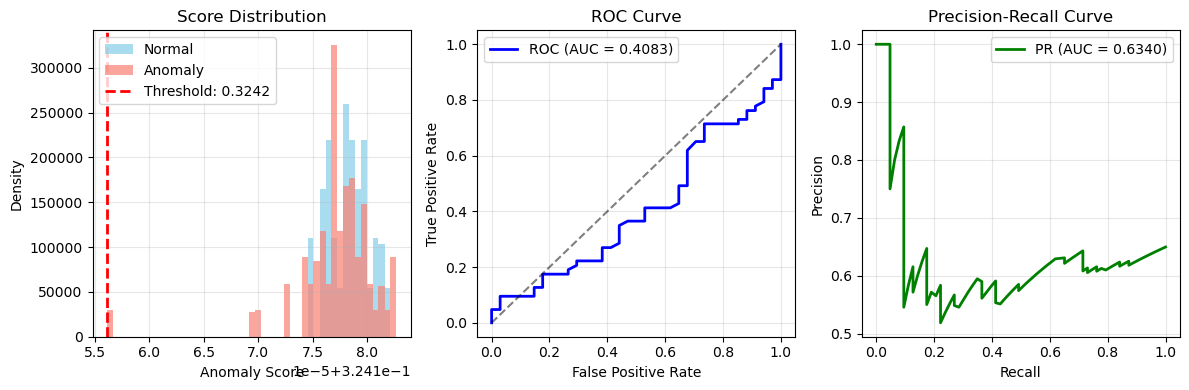

In [29]:
# 기본 분포 시각화
print("=== Basic Visualization ===")
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# 1. 점수 분포 히스토그램
bins = np.linspace(pred_scores.min(), pred_scores.max(), 50)
axes[0].hist(normal_scores.numpy(), bins=bins, alpha=0.7, label='Normal', color='skyblue', density=True)
axes[0].hist(anomaly_scores.numpy(), bins=bins, alpha=0.7, label='Anomaly', color='salmon', density=True)
axes[0].axvline(threshold_val, color='red', linestyle='--', linewidth=2, label=f'Threshold: {threshold_val:.4f}')
axes[0].set_xlabel('Anomaly Score')
axes[0].set_ylabel('Density')
axes[0].set_title('Score Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. ROC 곡선
fpr, tpr, _ = roc_curve(gt_labels.numpy(), pred_scores.numpy())
axes[1].plot(fpr, tpr, linewidth=2, color='blue', label=f'ROC (AUC = {results["auroc"]:.4f})')
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Precision-Recall 곡선
precision_curve, recall_curve, _ = precision_recall_curve(gt_labels.numpy(), pred_scores.numpy())
axes[2].plot(recall_curve, precision_curve, linewidth=2, color='green', label=f'PR (AUC = {results["aupr"]:.4f})')
axes[2].set_xlabel('Recall')
axes[2].set_ylabel('Precision')
axes[2].set_title('Precision-Recall Curve')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [30]:
# 저장된 결과와 비교
print("=== Comparison with Saved Results ===")
import glob

results_files = glob.glob(os.path.join(experiment_dir, "results_*.json"))
if results_files:
    latest_results_file = max(results_files, key=os.path.getctime)
    
    with open(latest_results_file, 'r') as f:
        saved_results = json.load(f)
    
    if 'results' in saved_results:
        saved_metrics = saved_results['results']
        print("Saved vs Current Results:")
        
        metrics_to_compare = ['auroc', 'aupr', 'f1', 'accuracy', 'precision', 'recall']
        for metric in metrics_to_compare:
            if metric in saved_metrics and metric in results:
                saved_val = saved_metrics[metric]
                current_val = results[metric]
                diff = abs(saved_val - current_val)
                print(f"{metric:>10}: {saved_val:.4f} vs {current_val:.4f} (diff: {diff:.6f})")
        
        # 전체적인 일치성 확인
        auroc_diff = abs(saved_metrics.get('auroc', 0) - results['auroc'])
        if auroc_diff < 0.001:
            print("\n✓ Results match saved values (difference < 0.001)")
        else:
            print(f"\n⚠ Results differ from saved values (AUROC diff: {auroc_diff:.6f})")
    else:
        print("No comparison data available in saved results")
else:
    print("No saved results files found")

=== Comparison with Saved Results ===
Saved vs Current Results:
     auroc: 0.4087 vs 0.4083 (diff: 0.000467)
      aupr: 0.6341 vs 0.6340 (diff: 0.000088)
        f1: 0.7875 vs 0.7875 (diff: 0.000000)
  accuracy: 0.6495 vs 0.6495 (diff: 0.000000)
 precision: 0.6495 vs 0.6495 (diff: 0.000000)
    recall: 1.0000 vs 1.0000 (diff: 0.000000)

✓ Results match saved values (difference < 0.001)


In [31]:
# 최종 요약 리포트
print("\n" + "="*60)
print("FINAL EVALUATION SUMMARY")
print("="*60)
print(f"Model: {config.model_type}")
print(f"Dataset: {config.dataloader_type} - {config.dataloader_params.get('categories', 'All')}")
print(f"Total samples: {total_count} (Normal: {normal_count}, Anomaly: {anomaly_count})")
print("-"*40)
print(f"AUROC:     {results['auroc']:.4f}")
print(f"AUPR:      {results['aupr']:.4f}")
print(f"F1-Score:  {results['f1']:.4f}")
print(f"Accuracy:  {results['accuracy']:.4f}")
print(f"Threshold: {results['threshold']:.6f}")
print("-"*40)
print(f"Classification Results:")
print(f"  Correctly classified: {tp + tn}/{total_count} ({(tp + tn)/total_count*100:.1f}%)")
print(f"  Missed anomalies:     {fn}/{anomaly_count} ({fn/anomaly_count*100:.1f}%)")
print(f"  False alarms:         {fp}/{normal_count} ({fp/normal_count*100:.1f}%)")
print("="*60)

# 성능 등급 평가
if results['auroc'] >= 0.9:
    performance_grade = "Excellent"
elif results['auroc'] >= 0.8:
    performance_grade = "Good"
elif results['auroc'] >= 0.7:
    performance_grade = "Fair"
else:
    performance_grade = "Poor"

print(f"\n🏆 Performance Grade: {performance_grade}")
print(f"✓ Evaluation completed successfully!")


FINAL EVALUATION SUMMARY
Model: vanilla_vae
Dataset: mvtec - ['bottle']
Total samples: 97 (Normal: 34, Anomaly: 63)
----------------------------------------
AUROC:     0.4083
AUPR:      0.6340
F1-Score:  0.7875
Accuracy:  0.6495
Threshold: 0.324156
----------------------------------------
Classification Results:
  Correctly classified: 6111/97 (6300.0%)
  Missed anomalies:     0/63 (0.0%)
  False alarms:         3298/34 (9700.0%)

🏆 Performance Grade: Poor
✓ Evaluation completed successfully!
